<a href="https://colab.research.google.com/github/albertorm/Data_Analytics_Coursework/blob/master/2_NN_DA_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NN regression for House price prediction

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import argparse
import locale
import os
#SKLEARN AND GOOGLE
from google.colab import auth
from google.colab import drive
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#TENSORFLOW AND KERAS
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam

In [0]:
drive.mount('/content/gdrive') #mount the googledrive
#!ls "/content/gdrive/My Drive/DA_Coursework/3. Data" #list the content

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##1 Read dataset from CSV file and apply the transformations

In [0]:
#READ DATASET FROM FILE
s_boroughs = pd.read_csv("/content/gdrive/My Drive/DA_Coursework/3. Data/londonBoroughs_realprice.csv")

In [0]:
#Convert Date to numerical value for the three datasets:
s_boroughs['dateOfTransfer'] = pd.to_datetime(s_boroughs['dateOfTransfer'])
s_boroughs['dateOfTransfer'] = s_boroughs['dateOfTransfer'].map(dt.datetime.toordinal)

In [0]:
# SETTING PROPERTY TYPE TO "OTHERS"
property_type = 'O'

# SETTING LOWER ADN UPPER PRICE BOUNDS FOR OUTLIERS
lower_price = 20000
upper_price = 30000000


#s_boroughs = s_boroughs[s_boroughs['propertyType']!=property_type]
#s_boroughs = s_boroughs[(s_boroughs['dateOfTransfer']>=lower_price) & (s_boroughs['price']<=upper_price)]

In [0]:
#Create the dummy values for categorical values (Property Type, Old/New, Duration, PPD)
s_boroughs = pd.concat([s_boroughs,pd.get_dummies(s_boroughs['propertyType'], prefix='prop_type')],axis=1)
s_boroughs = pd.concat([s_boroughs,pd.get_dummies(s_boroughs['oldNew'], prefix='oldNew')],axis=1)
s_boroughs = pd.concat([s_boroughs,pd.get_dummies(s_boroughs['duration'], prefix='duration')],axis=1)

s_boroughs.drop(columns=['Unnamed: 0','uniqueId','postCode','propertyType','PAON','SAON','street','locality','townCity','county','oldNew','duration','ppdCategoryType','recordStatus'],inplace=True)

In [0]:
#Divide the dataset in three boroughs:
df_lambeth = s_boroughs.loc[s_boroughs['district']=='LAMBETH'] 
df_croydon = s_boroughs.loc[s_boroughs['district']=='CROYDON']
df_westminster = s_boroughs.loc[s_boroughs['district']=='CITY OF WESTMINSTER']

In [0]:
#CALCULATE THE MEAN PER DAY
df_lambeth = df_lambeth.groupby('dateOfTransfer').mean().reset_index()
df_croydon = df_croydon.groupby('dateOfTransfer').mean()
df_westminster = df_westminster.groupby('dateOfTransfer').mean()

##2 Split by train and test

In [0]:
#TRAIN AND TEST SPLIT
(train, test) = train_test_split(df_lambeth, test_size=0.2, random_state=42)

##4 Normalization

In [0]:
#NORMALIZING THE OTHER COLUMNS
#initialize the column names of the continuous data
continuous = ['dateOfTransfer','prop_type_D', 'prop_type_F', 'prop_type_S','prop_type_T'
              #,'prop_type_O'
              ,'oldNew_N', 'oldNew_Y', 'duration_F', 'duration_L','duration_U']

# performin min-max scaling each continuous feature column to the range [0, 1]
cs = MinMaxScaler()
trainContinuous = cs.fit_transform(train[continuous])
testContinuous = cs.fit_transform(test[continuous])


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
#DEFINE THE TRAINING AND TEST DATAFRAMES WITH ALL COLUMNS EXCEPT PRICE
#trainX = train[continuous]
trainX = trainContinuous
#testX = test[continuous]
testX = testContinuous

In [0]:
#NORMALIZING THE PRICE
train_price = np.reshape(train["price"].values, (len(train["price"]),1))
test_price = np.reshape(test["price"].values, (len(test["price"]),1))

trainY = cs.fit_transform(train_price)
testY = cs.fit_transform(test_price)

##5 Define NN model using Keras

In [0]:
#CREATE THE MODEL AND PRINT THE SUMMARY
model = Sequential()
model.add(Dense(20, input_dim=trainX.shape[1], activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1, activation="linear"))
 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_32 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 11        
Total params: 441
Trainable params: 441
Non-trainable params: 0
_________________________________________________________________


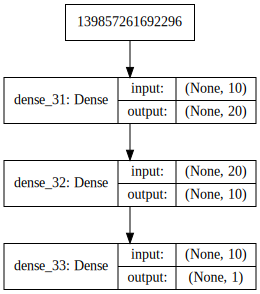

In [0]:
from IPython.display import SVG
from keras.utils import vis_utils

SVG(vis_utils.model_to_dot(model,show_shapes=True,show_layer_names=True).create(prog='dot',format='svg'))

In [0]:
#DEFINE THE LEARNING RATE AND COMPILE THE MODEL
epochsv = 20
lrv = 1e-3
batchv = 64
opt = Adam(lr=lrv
           ,decay=lrv / epochsv
          )

model.compile(loss="mean_squared_error", 
              optimizer=opt,
              metrics=['mean_absolute_error', 'mean_squared_error','accuracy']
              )

##6 Training the NN model

In [0]:
# train the model
print("[INFO] training model...")
history = model.fit(trainX, trainY
                    #,validation_data=(testX, testY)
                    ,epochs=epochsv
                    ,batch_size=batchv
                   )

[INFO] training model...
Epoch 1/20
5136/5136 [==============================] - 1s 167us/step - loss: 0.0032 - mean_absolute_error: 0.0344 - mean_squared_error: 0.0032 - acc: 1.9470e-04
Epoch 2/20
5136/5136 [==============================] - 0s 64us/step - loss: 8.9548e-04 - mean_absolute_error: 0.0150 - mean_squared_error: 8.9548e-04 - acc: 1.9470e-04
Epoch 3/20
5136/5136 [==============================] - 0s 66us/step - loss: 6.8107e-04 - mean_absolute_error: 0.0115 - mean_squared_error: 6.8107e-04 - acc: 1.9470e-04
Epoch 4/20
5136/5136 [==============================] - 0s 67us/step - loss: 6.0135e-04 - mean_absolute_error: 0.0099 - mean_squared_error: 6.0135e-04 - acc: 1.9470e-04
Epoch 5/20
5136/5136 [==============================] - 0s 64us/step - loss: 5.4840e-04 - mean_absolute_error: 0.0086 - mean_squared_error: 5.4840e-04 - acc: 1.9470e-04
Epoch 6/20
5136/5136 [==============================] - 0s 66us/step - loss: 5.2487e-04 - mean_absolute_error: 0.0083 - mean_squared_erro

##7 Evaluation and results

In [0]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


In [0]:
# TRAINING RMSE
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train RMSE: %.10f' % (trainScore))

# TEST RMSE
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test RMSE: %.10f' % (testScore))

Train RMSE: 0.0212015077
Test RMSE: 0.0418664847


In [0]:
# DE-NORMALIZING FOR PLOTTING
trainPredicti = cs.inverse_transform(trainPredict)
trainYi = cs.inverse_transform(trainY)
testPredicti = cs.inverse_transform(testPredict)
testYi = cs.inverse_transform(testY)

In [0]:
# TRAINING RMSE DE-NORMALIZED
trainScore = np.sqrt(mean_squared_error(trainYi, trainPredicti[:,0]))
print('Train RMSE: %.2f' % (trainScore))

# TEST RMSE
testScore = np.sqrt(mean_squared_error(testYi, testPredicti[:,0]))
print('Test RMSE: %.2f' % (testScore))

Train RMSE: 109662.98
Test RMSE: 216550.81


Train RMSE: 69367.54
Test RMSE: 143270.21

In [0]:
# TRAINING MSE DE-NORMALIZED
trainScore = mean_squared_error(trainYi, trainPredicti[:,0])
print('Train MSE: %.2f' % (trainScore))

# TEST MSE
testScore = mean_squared_error(testYi, testPredicti[:,0])
print('Test MSE: %.2f' % (testScore))

Train MSE: 12025970050.66
Test MSE: 46894253080.25


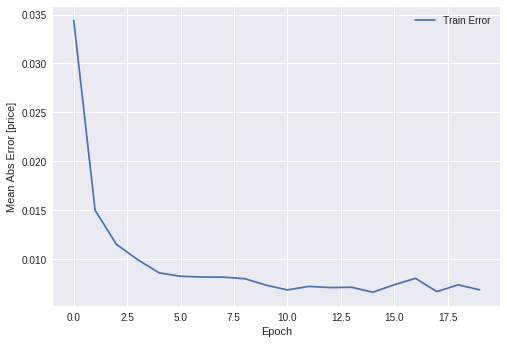

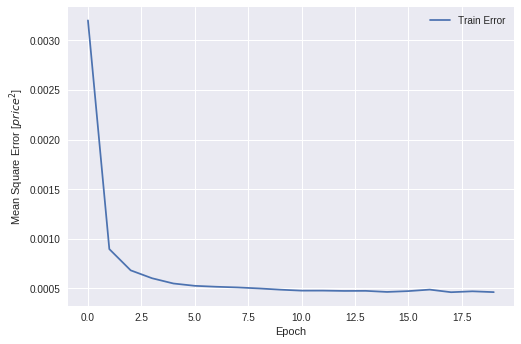

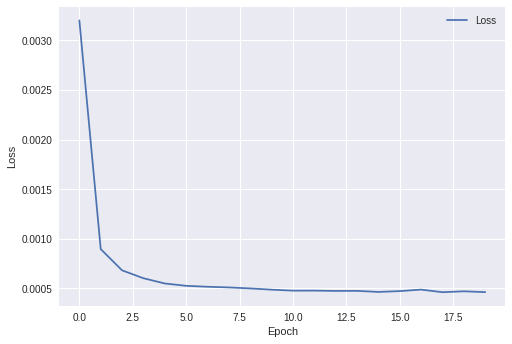

In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [price]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  #plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
  #         label='Test Error')
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$price^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  #plt.plot(hist['epoch'], hist['val_mean_squared_error'],
  #         label='Test Error')
  plt.legend()
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Loss')
  #plt.plot(hist['epoch'], hist['val_loss'],
  #         label='Val Loss')
  plt.legend()
  plt.show()

plot_history(history)